In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import collections 
import time
import glob
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
fall_data_dir = "/workspace/inkyung/Fall Detection/Mobidata_resampled(Smartfall)/fall/*.csv"
adl_data_dir = "/workspace/inkyung/Fall Detection/Mobidata_resampled(Smartfall)/adl/*.csv"

### Preprecessing

- sliding window size of 40
- if data contains all fall samples(30 samples) then label as 'FALL'
- unless, it's all labelled as 'ADL'

In [4]:
n = 40
fall_X_list, fall_y_list = list(), list()
for file in tqdm.notebook.tqdm(glob.glob(fall_data_dir)):
    data = pd.read_csv(file)
    for i in range(0, len(data) - 40):
        temp = list()
        temp.append(data['acc_x'][i : i + n])
        temp.append(data['acc_y'][i : i + n])
        temp.append(data['acc_z'][i : i + n])
        
        cnt = collections.Counter(data['label'][i: i + n])
        num_adl = cnt[0]
        num_fall = cnt[1]
        if num_fall == 30:
            fall_X_list.append(temp)
            fall_y_list.append(1)
        else:
            print('ADL')

ADL
ADL
ADL
ADL
ADL



In [6]:
n = 40
adl_X_list, adl_y_list = list(), list()
for file in tqdm.notebook.tqdm(glob.glob(adl_data_dir)):
    data = pd.read_csv(file)
    for i in range(0, len(data) - 40):
        temp = list()
        temp.append(data['acc_x'][i : i + n])
        temp.append(data['acc_y'][i : i + n])
        temp.append(data['acc_z'][i : i + n])
        
        adl_X_list.append(temp)
        adl_y_list.append(0)

In [8]:
# to keep the balance between ADL and FALL data, used only the part of ADL data

print('the length of fall data', len(fall_X_list))
adl_X_list = adl_X_list[:7665]
adl_y_list = adl_y_list[:7665]

X_data = fall_X_list + adl_X_list
y_data = fall_y_list + adl_y_list

print('the total length of X data', len(X_data))

the length of fall data 7665
the total length of X data 15330


In [9]:
# splitting data into train, validation, test set
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [10]:
X_train = np.asarray(X_train).reshape(-1, 40, 3)
y_train = np.asarray(y_train).reshape(-1, )

X_valid = np.asarray(X_valid).reshape(-1, 40, 3)
y_valid = np.asarray(y_valid).reshape(-1, )

X_test = np.asarray(X_test).reshape(-1, 40, 3)
y_test = np.asarray(y_test).reshape(-1, )

In [11]:
print('size of X_train', X_train.shape)
print('size of y_train', y_train.shape)
print('------------------------------')
print('size of X_valid', X_valid.shape)
print('size of y_valid', y_valid.shape)
print('------------------------------')
print('size of X_test', X_test.shape)
print('size of y_test', y_test.shape)

size of X_train (8584, 40, 3)
size of y_train (8584,)
------------------------------
size of X_valid (3680, 40, 3)
size of y_valid (3680,)
------------------------------
size of X_test (3066, 40, 3)
size of y_test (3066,)


In [12]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_valid = enc.fit_transform(y_valid)
y_test = enc.fit_transform(y_test)

In [13]:
print(y_test)
print(y_valid)
print(y_train)

[0 0 1 ... 0 0 1]
[0 1 1 ... 1 1 0]
[0 0 0 ... 0 0 1]


In [14]:
batch_size = 128

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train_data,
                                           shuffle=True,
                                           batch_size=batch_size)

valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           shuffle=True,
                                           batch_size=batch_size)

test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(test_data,
                                          shuffle=True,
                                          batch_size=batch_size)

In [15]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1]))
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

### Implementing cyclic learning rate
- implmenting a simple cosine scheduler

In [16]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [17]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

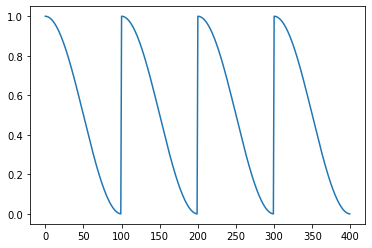

In [18]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [19]:
input_dim = next(iter(test_loader))[0].shape[2]
output_dim = 2
n_layers = 2
hidden_dim = 256

lr = 0.000001
n_epochs = 200
iterations_per_epoch = len(test_loader)
best_acc = 0.
patience, trials = 15, 0

model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers).cuda()
print(model)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sched = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min = lr/10))
epoch_times = []

LSTMNet(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)


In [20]:
"""
relearning the model using pretrained model by SmartFall data
"""
model.load_state_dict(torch.load('SmartFall_lstm.pth'))
train_loss, train_acc = list(), list()
for epoch in range(1, n_epochs + 1):
    start_time = time.process_time()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        prediction = F.log_softmax(out, dim=1).argmax(dim=1)
        sched.step()
    current_time = time.process_time()
    epoch_times.append(current_time-start_time)
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in valid_loader:
        x_val, y_val = [t.cuda() for t in (x_val.float(), y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
        
    acc = correct / total
    train_loss.append(loss.item())
    train_acc.append(acc)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')
        
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'SmartFall_lstm_transfer_learning_to_MobiAct.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
print("Total Training Time: {} seconds".format(str(sum(epoch_times))))

Epoch 1 best model saved with accuracy: 86.17%
Epoch 2 best model saved with accuracy: 87.15%
Epoch 3 best model saved with accuracy: 87.69%
Epoch 4 best model saved with accuracy: 88.53%
Epoch:   5. Loss: 0.1169. Acc.: 89.02%
Epoch 5 best model saved with accuracy: 89.02%
Epoch 6 best model saved with accuracy: 89.70%
Epoch 7 best model saved with accuracy: 90.08%
Epoch 8 best model saved with accuracy: 90.52%
Epoch 9 best model saved with accuracy: 90.95%
Epoch:  10. Loss: 0.0764. Acc.: 91.25%
Epoch 10 best model saved with accuracy: 91.25%
Epoch 11 best model saved with accuracy: 91.77%
Epoch 12 best model saved with accuracy: 91.93%
Epoch 13 best model saved with accuracy: 92.20%
Epoch 14 best model saved with accuracy: 92.39%
Epoch:  15. Loss: 0.1250. Acc.: 92.55%
Epoch 15 best model saved with accuracy: 92.55%
Epoch 16 best model saved with accuracy: 92.88%
Epoch 17 best model saved with accuracy: 93.42%
Epoch 18 best model saved with accuracy: 93.78%
Epoch 19 best model saved wi

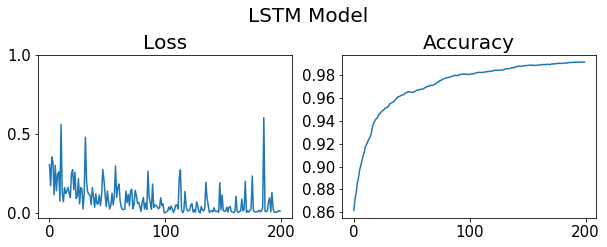

In [25]:
plt.figure(figsize=(10, 3))
plt.suptitle('LSTM Model', fontsize=20, y=1.1)
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss)), train_loss)
plt.yticks([0.0, 0.5, 1.0], fontsize=15)
plt.xticks([0, 100, 200], fontsize=15)
plt.title('Loss', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acc)), train_acc)
plt.yticks(fontsize=15)
plt.xticks([0, 100, 200], fontsize=15)
plt.title('Accuracy',fontsize=20)
plt.subplots_adjust(hspace=1)

plt.show()

In [26]:
lstm_transfer = pd.DataFrame(train_loss)
lstm_transfer.columns = ['train_loss']
lstm_transfer['train_acc'] = pd.DataFrame(train_acc)
lstm_transfer.to_csv('lstm_transfer')

In [27]:
# evaluation with test dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

targets = list()
preds = list()
correct = 0
model.load_state_dict(torch.load('SmartFall_lstm_transfer_learning_to_MobiAct.pth'))
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.cuda(), y.cuda()
        output = model(X.float())
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()

        targets += list(y.cpu().numpy())
        preds += list(pred.cpu().numpy())

test_acc = 100. * correct / len(test_loader.dataset)
confusion_mtx = confusion_matrix(targets, preds)
print(test_acc)
print(confusion_mtx)

99.31506849315069
[[1528   10]
 [  11 1517]]


In [28]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1538
           1       0.99      0.99      0.99      1528

    accuracy                           0.99      3066
   macro avg       0.99      0.99      0.99      3066
weighted avg       0.99      0.99      0.99      3066



In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('precision score: ', precision_score(targets, preds))
print('recall score: ', recall_score(targets, preds))
print('f1 score: ', f1_score(targets, preds))

precision score:  0.9934512115258677
recall score:  0.9928010471204188
f1 score:  0.9931260229132569
